In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import Sequential, Conv2d, MaxPool2d, Dropout2d, CrossEntropyLoss, ReLU, Linear, Flatten, Module, BatchNorm2d, AvgPool2d
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import affine

from torchinfo import summary

from scipy.interpolate import interp2d, RectBivariateSpline
from scipy import ndimage

import kornia

from ActiveShiftLayer import ASL

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


In [11]:
batch_size = 100

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
#                                         download=True, transform=transform)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
#                                        download=True, transform=transform)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

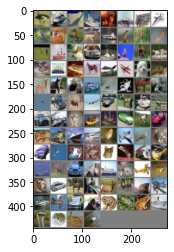

bird  ship  plane ship  dog   plane truck plane bird  cat   horse deer  ship  bird  deer  cat   deer  ship  dog   car   dog   bird  deer  horse deer  ship  frog  horse plane plane dog   frog  deer  horse cat   ship  deer  cat   horse frog  plane truck deer  plane car   horse dog   plane car   plane bird  ship  deer  car   horse car   horse truck ship  ship  bird  plane bird  cat   car   bird  dog   frog  cat   cat   truck car   ship  deer  car   bird  ship  dog   plane frog  cat   car   horse cat   deer  deer  ship  plane ship  bird  car   dog   frog  frog  frog  ship  bird  frog  bird  frog 


In [4]:
# print(train_dataset.data.shape)
# train_dataset.data = np.transpose(train_dataset.data, axes=(0,3,2,1))
# print(train_dataset.data.shape)
# plt.imshow(train_dataset.data[0,1])

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
def test_loss(NN, criterion):
    correct = 0
    total = 0
    total2 = 0
    loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = NN(images)
            loss += criterion(outputs, labels).item()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            total2 += 1
            correct += (predicted == labels).sum().item()
    
    return loss/total2, 100 * correct / total

In [6]:
from Models import smallASL

In [7]:


p_drop = 0.05
input_shape = (batch_size, 3, 32, 32)

NN = smallASL((batch_size, 3, 32, 32), 10, p_drop=p_drop)

summary(NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
smallASL                                 --                        --
├─Sequential: 1-1                        --                        --
│    └─ASL: 2-1                          [100, 3, 32, 32]          6
│    └─Conv2d: 2-2                       [100, 32, 32, 32]         128
│    └─MaxPool2d: 2-3                    [100, 32, 16, 16]         --
│    └─ASL: 2-4                          [100, 32, 16, 16]         64
│    └─Conv2d: 2-5                       [100, 64, 16, 16]         2,112
│    └─Dropout2d: 2-6                    [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-7                    [100, 64, 8, 8]           --
│    └─Dropout2d: 2-8                    [100, 64, 8, 8]           --
│    └─ASL: 2-9                          [100, 64, 8, 8]           128
│    └─Conv2d: 2-10                      [100, 128, 8, 8]          8,320
│    └─MaxPool2d: 2-11                   [100, 128, 4, 4]          --
│    └─D

In [62]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(NN.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [64]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = NN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN, criterion))
    scheduler.step()


[1,   100] train_loss: 1.140
(1.1271909439563752, 60.66)
[1,   200] train_loss: 1.098
(1.1412443959712981, 60.29)
[1,   300] train_loss: 1.118
(1.12335939347744, 61.24)
[1,   400] train_loss: 1.100
(1.149676629304886, 59.98)
[1,   500] train_loss: 1.079
(1.1052989637851716, 61.75)
[2,   100] train_loss: 1.053
(1.0694124925136566, 62.89)
[2,   200] train_loss: 1.014
(1.0623246532678605, 63.7)
[2,   300] train_loss: 1.026
(1.0578158342838286, 63.48)
[2,   400] train_loss: 1.010
(1.0527627581357957, 63.82)
[2,   500] train_loss: 1.018
(1.0528117913007735, 64.21)


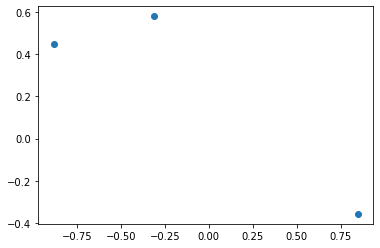

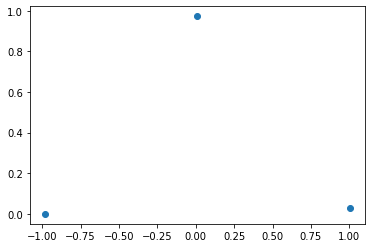

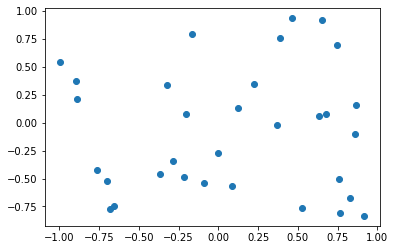

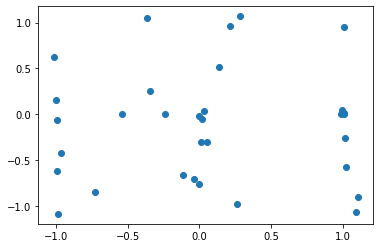

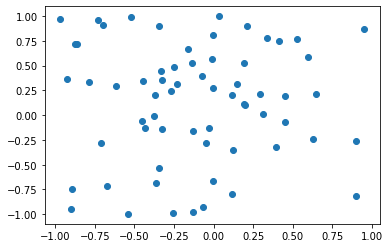

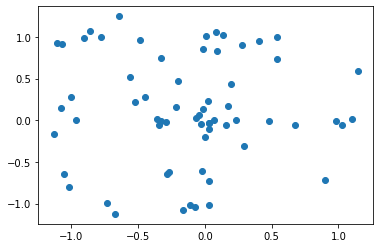

In [65]:
points = NN[0].shifts.detach().numpy()
initial_points = NN[0].initial.detach().numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

points = NN[3].shifts.detach().numpy()
initial_points = NN[3].initial.detach().numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

points = NN[8].shifts.detach().numpy()
initial_points = NN[8].initial.detach().numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [68]:
p_drop = 0.05

NN_conv = Sequential(Conv2d(3, 32, (5, 5), padding="same"),
                MaxPool2d(2,2),
                Dropout2d(p_drop),
                Conv2d(32, 64, 5, padding="same"),
                MaxPool2d(2,2),
                Dropout2d(p_drop),
                Conv2d(64, 128, 2, padding="same"),
                MaxPool2d(2,2),
                Dropout2d(p_drop),
                ReLU(),
                Flatten(),
                Linear(16*128, 10)
                )

summary(NN_conv, (batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [100, 10]                 --
├─Conv2d: 1-1                            [100, 32, 32, 32]         2,432
├─MaxPool2d: 1-2                         [100, 32, 16, 16]         --
├─Dropout2d: 1-3                         [100, 32, 16, 16]         --
├─Conv2d: 1-4                            [100, 64, 16, 16]         51,264
├─MaxPool2d: 1-5                         [100, 64, 8, 8]           --
├─Dropout2d: 1-6                         [100, 64, 8, 8]           --
├─Conv2d: 1-7                            [100, 128, 8, 8]          32,896
├─MaxPool2d: 1-8                         [100, 128, 4, 4]          --
├─Dropout2d: 1-9                         [100, 128, 4, 4]          --
├─ReLU: 1-10                             [100, 128, 4, 4]          --
├─Flatten: 1-11                          [100, 2048]               --
├─Linear: 1-12                           [100, 10]                 20,490


In [69]:
criterion = CrossEntropyLoss()
optimizer_conv = optim.SGD(NN_conv.parameters(), lr=0.05, momentum=0.9)
scheduler_conv = optim.lr_scheduler.ExponentialLR(optimizer_conv, gamma=0.9)

In [71]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_conv.zero_grad()

        # forward + backward + optimize
        outputs = NN_conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_conv.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN_conv, criterion))

    scheduler_conv.step()

[1,   100] train_loss: 1.423
(1.4699228692054749, 49.32)
[1,   200] train_loss: 1.399
(1.4379331636428834, 52.12)
[1,   300] train_loss: 1.372
(1.5203810298442841, 50.53)
[1,   400] train_loss: 1.441
(1.3832951110601426, 53.05)
[1,   500] train_loss: 1.453
(1.4115547299385072, 49.98)
[2,   100] train_loss: 1.314
(1.3076655286550523, 55.99)
[2,   200] train_loss: 1.321
(1.3692091143131255, 54.69)
[2,   300] train_loss: 1.257
(1.3518441462516784, 55.78)
[2,   400] train_loss: 1.311
(1.4614167726039886, 51.52)
[2,   500] train_loss: 1.314
(1.2943918472528457, 55.59)
